<b>EDA - Exploratory Data Analysis</b>

This notebook performs exploratory data analysis on the brain MRI segmentation dataset.
You will see:

- Dataset sizes (train/test)

- Number of slices per volume

- Voxel spacing (if available)

- Intensity distributions

- Class mask counts & tumor‐pixel ratios

- Example slice visualizations

In [ ]:
### IMPORTS ###
# enable autoreload
%load_ext autoreload
%autoreload 2
import sys, os
import matplotlib.pyplot as plt
from pathlib import Path
# point at the project’s src/ folder
sys.path.insert(0, os.path.abspath(os.path.join("..", "src")))

from src.utils.eda import gather_stats, plot_distributions
import matplotlib.pyplot as plt

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


First 5 cases:


,case,mean_int,std_int,min_int,max_int,dim_x,dim_y,num_slices,slices_with_tumor,class0_voxels,class1_voxels,class2_voxels,pct_tumor
0,10,39.818806,58.527554,0.0,422.0,512,512,75,22,19633933,8009,18858,0.136653
1,101,36.267269,57.631306,0.0,428.0,512,512,82,33,21470258,3051,22499,0.118860
2,103,23.574316,36.608730,0.0,410.0,512,512,74,34,19353358,8277,37021,0.233511
3,107,47.189144,67.326729,0.0,387.0,512,512,65,18,17033700,0,5660,0.033217
4,109,32.654705,52.548893,0.0,411.0,512,512,67,30,17543079,4665,15904,0.117111


Summary stats:


,mean_int,std_int,min_int,max_int,dim_x,dim_y,num_slices,slices_with_tumor,class0_voxels,class1_voxels,class2_voxels,pct_tumor
count,130.000000,130.000000,130.0,130.000000,130.000000,130.000000,130.000000,130.000000,1.300000e+02,130.000000,130.000000,130.000000
mean,44.700178,99.275916,0.0,1465.053071,522.953846,522.461538,84.792308,34.330769,2.347586e+07,18085.015385,24906.938462,0.198465
std,28.999122,90.925251,0.0,2064.008160,30.929994,31.355465,23.667168,18.201452,8.846294e+06,18534.333119,35275.402917,0.184329
min,15.997896,29.151152,0.0,346.000000,512.000000,480.000000,57.000000,7.000000,1.489171e+07,0.000000,0.000000,0.005772
25%,32.288571,57.396389,0.0,414.250000,512.000000,512.000000,70.000000,24.000000,1.838566e+07,5561.500000,3869.750000,0.076183
50%,42.854082,64.395615,0.0,465.500000,512.000000,512.000000,76.000000,30.000000,2.013281e+07,11125.000000,16323.000000,0.152454
75%,49.787293,74.509964,0.0,858.750000,512.000000,512.000000,85.750000,39.000000,2.600783e+07,26021.750000,34651.250000,0.263893
max,329.909943,524.900330,0.0,9887.296875,640.000000,640.000000,162.000000,105.000000,6.632089e+07,87054.000000,299865.000000,1.200418


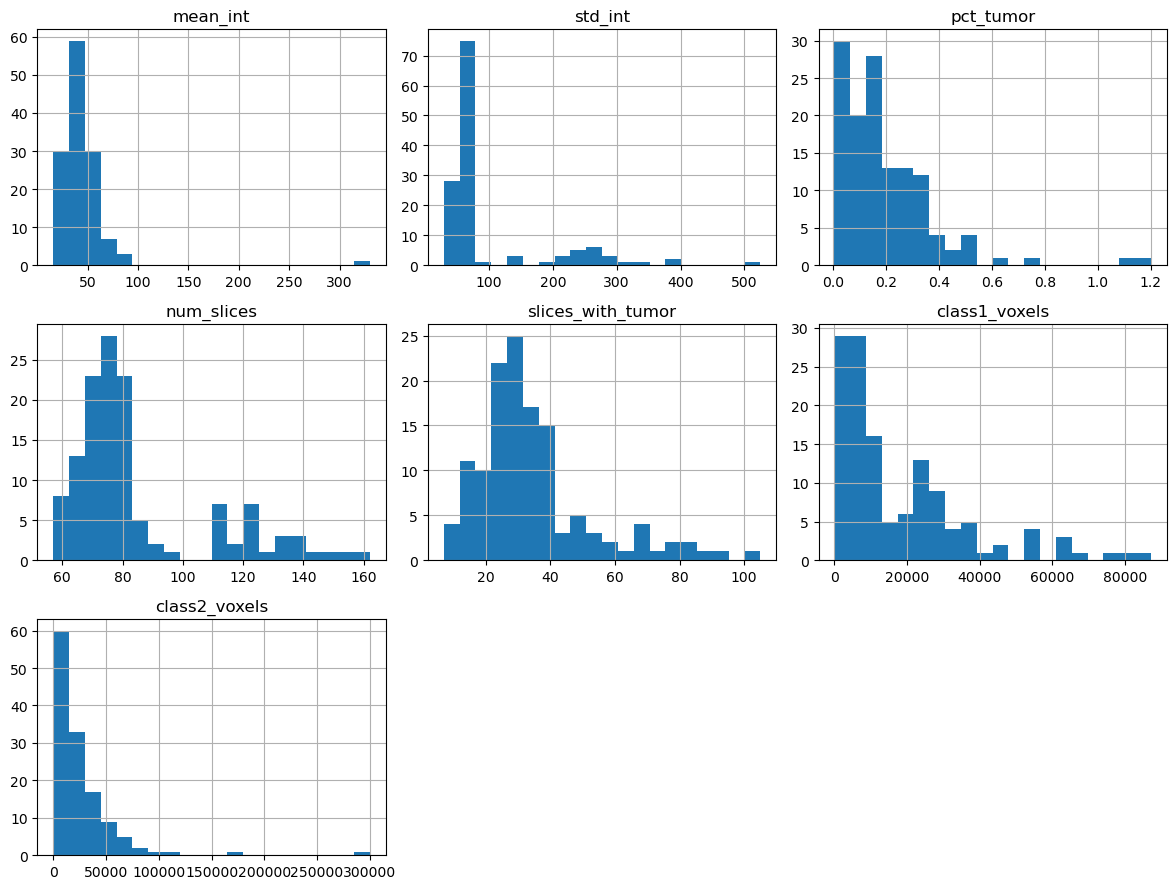

In [5]:
DATA_DIR = "/datasets/tdt4265/mic/open/HNTS-MRG"
df = gather_stats(DATA_DIR)
print("First 5 cases:")
display(df.head())
print("Summary stats:")
display(df.describe())

# Plot all histograms at once:
plot_distributions(df)


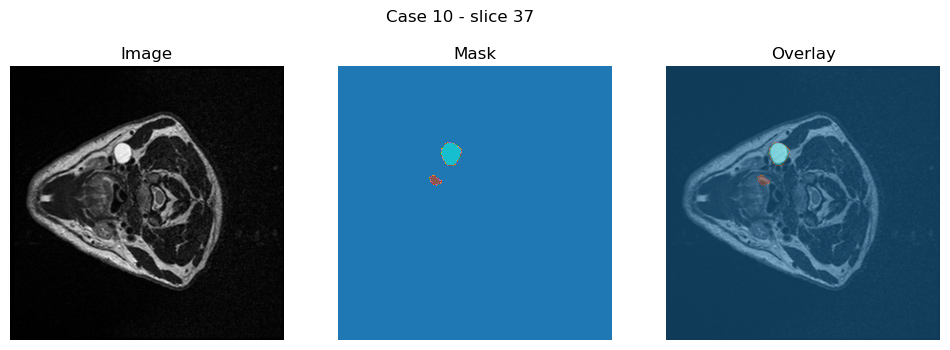

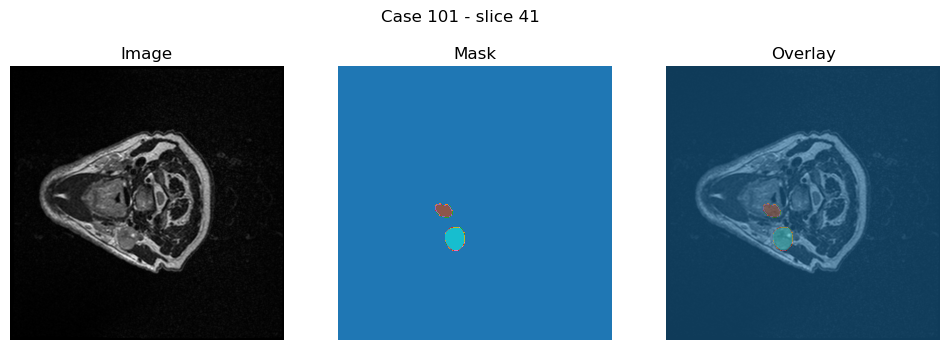

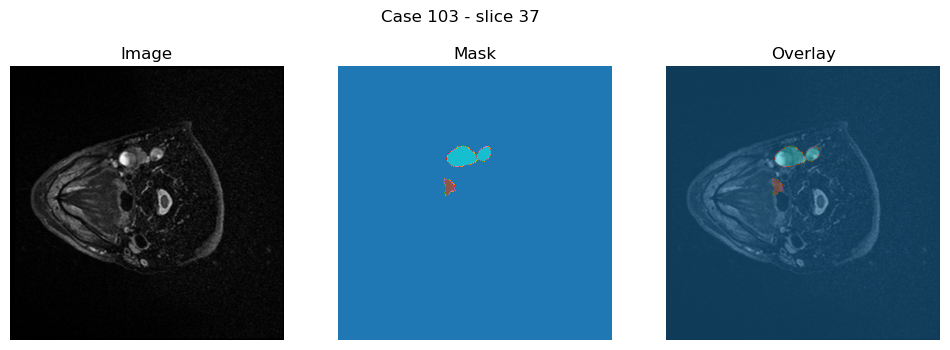

In [6]:
import nibabel as nib

for i, case in enumerate(df["case"].tolist()[:3]):
    preRT = os.path.join(DATA_DIR, "train", case, "preRT")
    img_file  = next(Path(preRT).glob("*T2.nii.gz"))
    mask_file = next(Path(preRT).glob("*mask.nii.gz"))

    img = nib.load(str(img_file)).get_fdata()
    lbl = nib.load(str(mask_file)).get_fdata()

    mid = img.shape[2] // 2
    fig, axes = plt.subplots(1,3, figsize=(12,4))
    axes[0].imshow(img[:,:,mid], cmap="gray");            axes[0].set_title("Image")
    axes[1].imshow(lbl[:,:,mid], cmap="tab10");           axes[1].set_title("Mask")
    axes[2].imshow(img[:,:,mid], cmap="gray")
    axes[2].imshow(lbl[:,:,mid], cmap="tab10", alpha=0.5); axes[2].set_title("Overlay")
    for ax in axes: ax.axis("off")
    plt.suptitle(f"Case {case} - slice {mid}")
    plt.show()

